# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import Input, Model, backend as K
import numpy as np
import matplotlib.pyplot as plt
print("Tensorflow version: ", tf.__version__)
from IPython.display import display

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

import time
# Needed for saving
import pandas as pd

# Enable the TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)

print("All devices: ", *tf.config.list_logical_devices("TPU"), sep="\n\t")

Tensorflow version:  2.12.0
All devices: 
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')


# Load in the data

In [2]:
# Get path by linking first, then selecting the file w/ right mouse button; 'get path'
labels = np.load('/content/drive/MyDrive/IDL/A1/labels.npy')
data = np.load('/content/drive/MyDrive/IDL/A1/images.npy')


labels_m = labels[:, 1]
labels_h = labels[:, 0]
data.shape

# Add hours and minutes into one array
labels_h_m = np.column_stack([labels_h, labels_m])
labels_h_m.shape
labels_h_m


# Shape for data input
data.reshape(data.shape[0], *(150, 150, 1)).shape

(18000, 150, 150, 1)

# Common sense time:

In [3]:
def common_sense_time(y_true, y_pred):
  try:
    predicted_min = y_pred[0]*60+y_pred[1]
    actual_min = y_true[0]*60+y_true[1]
  except:
    tf.cast(y_pred|y_true, tf.float32|tf.float32)
    predicted_min = y_pred[0]*60+y_pred[1]
    actual_min = y_true[0]*60+y_true[1]
  return (actual_min - predicted_min)%720

In [12]:
common_sense_time([11, 55], [0, 5])
common_sense_time([0, 5], [11.01, 55])

# Check if reshaped labels work
# print(labels_h_m[0], labels_h_m[-1])
# common_sense_time(labels_h_m[0], labels_h_m[-1])

9.399999999999977

#### Example of one data clock

In [39]:
np.max(data[0,:,:]/255.0)

1.0

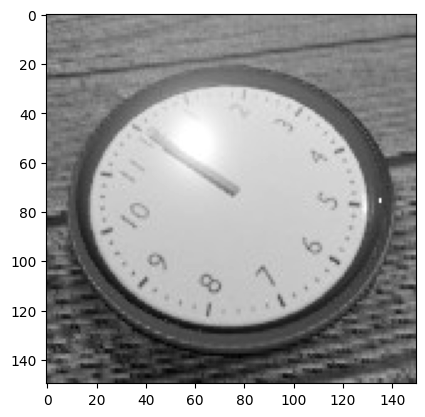

In [ ]:
plt.imshow(data[0,:,:], cmap='gray')
plt.show()

# Define the functions to make a network

In [3]:
def make_model(arch, optimizer,
               metrics: list = ["accuracy"],
               steps_per_execution: int = 1,
               summary_model: bool = False):

  # Create a dictionary of possible layers. In this case we can create any arbitary network
  # without having to constantly copy and paste lines.
  layer_dict = {
        "dense": Dense,             # units, activation=None
        "dropout": Dropout,         # rate, noise_shape=None, seed=None
        "conv": Conv2D,             # filters, kernel_size, strides=(1, 1), padding="valid", activation=None
        "maxpooling": MaxPooling2D, # pool_size=(2, 2), strides=None, padding="valid"
        "flatten": Flatten,
        "BN": BatchNormalization,
  }

  ##########################################

  # Initiate model
  model = keras.models.Sequential()

  ## Add input layer
  model.add(Input(shape=arch['input_shape']))

  ## Add layers
  for layer, kwargs in arch['layers']:
    # Use our dictionary to obtain the callable layer and put in the keywords arguments
    model.add(layer_dict[layer](**kwargs))

  # Output layer
  model.add(layer_dict[arch['output'][0]](**arch['output'][1]))

  ##########################################

  # Print summary if wanted
  if summary_model:
    model.summary()

  model.compile(loss="sparse_categorical_crossentropy", #common_sense_time,
                optimizer=optimizer,
                metrics=metrics,
                steps_per_execution=steps_per_execution)

  # Return model before fitting
  return model


def fit_model(model, X_train, y_train, scaling,
              epochs: int = 30, validation_split: float = 0.1,
              batch: int = 64, verbose: int = 0):

  history = model.fit(X_train/scaling, y_train, epochs=epochs,
                    validation_split = validation_split, batch_size=batch, verbose=verbose) # verbose=0 is stfu

  return history


def eval_model(model, X_test, y_test, batch, verbose=1):
  return model.evaluate(X_test, y_test, batch_size=batch, verbose=verbose)


# Creating the architecture:

Given on Brightspace was the hint for having a number of parameters between 256 and 2048 for the last layer. Else the network would be too complex, leading to very long fitting times, as well as the possibility of having no convergence in a sufficient amount of time.

In [4]:
classification_model_h ={
    'input_shape':(150, 150, 1),
    # Output (we have in total 720 classes of time, 60*12, each with a given probability per item (returned by Softmax), but start by classes of 30 minutes)
    'output': ('dense', {'units': 12, 'activation': 'softmax'}),

    'layers':[
        ('conv', {'filters': 9, 'kernel_size': 17, 'activation': 'relu'}),
        # An image has about 8 in height and 8 in width of freedom before having the clock in the image. So reduce the size using the kernel to have the clock in frame
        # Furthermore, 150/17 ~ 9, leaving 9 filters in total.
        ('maxpooling', {'pool_size': (2,2)}),
        ("BN", {}),

        # Now for the numbers on the clock. Say that a number is indicated in a size of about 15x15
        ('conv', {'filters': 12, 'kernel_size': 15, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),
        ("BN", {}),

        # Arrows on the clock. Given the 15x15 block we are in from the previous layer, make a kernel of 3x3
        # to seek the arrow indication. We need about 15*15/3*3 = 25 filters.
        ('conv', {'filters': 25, 'kernel_size': 3, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),



        # ('conv', {'filters': 256, 'kernel_size': 3, 'activation': 'relu'}),
        # ('maxpooling', {'pool_size': (2,2)}),
        # ("BN", {}),
        # ('conv', {'filters': 256, 'kernel_size': 3, 'activation': 'relu'}),
        # ('conv', {'filters': 256, 'kernel_size': 3, 'activation': 'relu'}),
        # ('maxpooling', {'pool_size': (2,2)}),
        # ("BN", {}),


        ('flatten', {}),
        ("BN", {}),
        ('dense', {'units': 60, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
        ('dense', {'units': 40, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
        ('dense', {'units': 30, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
        ('dense', {'units': 10, 'activation': 'relu'}),
        ('dense', {'units': 2, 'activation': 'relu'}),
        #
        # ('dense', {'units': 60, 'activation': 'relu'}),
        # ('dropout', {'rate': 0.5}),
    ]
}
make_model(classification_model_h, optimizer=keras.optimizers.Adam(),
          steps_per_execution=250, summary_model=True)

# display(keras.utils.plot_model(make_model(classification_model, optimizer=keras.optimizers.Adam(),
#            steps_per_execution=100, summary_model=False), show_layer_activations=True))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 134, 134, 9)       2610      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 67, 9)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 67, 67, 9)        36        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 12)        24312     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 12)       0         
 2D)                                                             
                                                        

# Fit model:

In [7]:
model_h = make_model(classification_model_h, optimizer=keras.optimizers.Adam(),
          steps_per_execution=100, summary_model=False)


model_h.save('/content/model_h.keras')

In [8]:
import os
# Get file size in bytes for a given model
os.stat('model_h.keras').st_size / 10**6

1.116892

In [9]:
data.reshape(data.shape[0], *classification_model_h['input_shape']).shape

(18000, 150, 150, 1)

In [10]:
# Model for hours

# fit_model(mod, X_train_full.reshape(60000, 784), y_train_full, 255.0,
#                           verbose=1)

fitted_model1 = fit_model(model_h, data.reshape(data.shape[0], *classification_model_h['input_shape']), labels_h, 255.0, epochs=5,
                            verbose=1, batch=64, validation_split=0.2)

Epoch 1/5
225/225 [==============================] - 291s 1s/step - loss: 2.4990 - accuracy: 0.0408 - val_loss: 2.7217 - val_accuracy: 0.0000e+00
Epoch 2/5
225/225 [==============================] - 285s 1s/step - loss: 2.4186 - accuracy: 0.0103 - val_loss: 2.9299 - val_accuracy: 0.0000e+00
Epoch 3/5
225/225 [==============================] - 285s 1s/step - loss: 2.3928 - accuracy: 0.0022 - val_loss: 3.1142 - val_accuracy: 0.0000e+00
Epoch 4/5
225/225 [==============================] - 285s 1s/step - loss: 2.3727 - accuracy: 0.0065 - val_loss: 3.2777 - val_accuracy: 0.0000e+00
Epoch 5/5
225/225 [==============================] - 284s 1s/step - loss: 2.3591 - accuracy: 0.0071 - val_loss: 3.4266 - val_accuracy: 0.0000e+00
